In [50]:
# import lovelyplots
import lovelyplots
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import scienceplots
from matplotlib import tri
from matplotlib.colors import TwoSlopeNorm
from qutip import (
    average_gate_fidelity,
    destroy,
    qeye,
    tensor,
)
from qutip_qip.operations import ISWAP, SQRTISWAP
from tqdm.notebook import tqdm

In [51]:
# params
N = 50
g3 = 60e6  # (g3 = 60 Mhz / 2pi)
lambdaq = 0.1
n_s_list = np.linspace(1, 5, N)  # sqrt of pump photon number in SNAIL mode
delta_list = 1e6 * np.linspace(50, 200, 6)  # MHz

# full_pulse = geff * t_f => geff = full_pulse / t_f
# pi/2 pulse for iSWAP, pi/4 for sqrtiSWAP
if True:
    full_pulse = np.pi / 2
    intended_gate = ISWAP([0, 1]).get_compact_qobj()
else:
    full_pulse = np.pi / 4
    intended_gate = SQRTISWAP([0, 1]).get_compact_qobj()

# define qutip ladder operators
q = destroy(2)
q1 = tensor(q, qeye(2), qeye(2), qeye(2))
q2 = tensor(qeye(2), q, qeye(2), qeye(2))
q3 = tensor(qeye(2), qeye(2), q, qeye(2))
q4 = tensor(qeye(2), qeye(2), qeye(2), q)
q1dag = q1.dag()
q2dag = q2.dag()
q3dag = q3.dag()
q4dag = q4.dag()

In [52]:
fidelity_dict = {}  # to store fidelity values for each delta
tf_dict = {}  # to store g_eff values for each delta
eta_dict = {}
for delta in tqdm(delta_list):
    fidelity_list = []
    tf_list = []  # store g_eff for this delta
    eta_list = []
    for n_s in n_s_list:
        eta = np.sqrt(n_s)
        g_eff = 6 * eta * g3 * (lambdaq**2)
        t_f = full_pulse / g_eff

        # H(t) = g_eff * exp(-i * delta * t) * interaction_term
        interaction_term = q1dag * q2 + q1 * q2dag
        spectator_term = q3dag * q4 + q3 * q4dag
        # spectator_term = q3dag + q3

        # Integral of the exponential factor
        # integral_term = (1j *(-1 + np.cos(t_f * delta)))/delta + np.sin(t_f * delta)/delta
        integral_term = 2 * np.sin(t_f * delta / 2) / delta
        # better_integral_term = (
        #     np.sin(t_f * delta) / delta + 1j * (1 - np.cos(t_f * delta)) / delta
        # )
        # integral_term = better_integral_term

        # Time evolution operator U(t_f)
        # NOTE sqrt(2) to scale to scale spectator to be on both left and right of intended
        multiple_scale_factor = 1  # / np.log(2)
        U_t_f = (
            1j
            * g_eff
            * (
                t_f * interaction_term
                + multiple_scale_factor * integral_term * (spectator_term)
            )
        ).expm()

        # Fidelity calculation
        # Define the target iSWAP gate
        # target_iswap = tensor(ISWAP([0, 1]).get_compact_qobj(), qeye([2, 2]))
        target_iswap = tensor(intended_gate, qeye([2, 2]))
        fidelity = 1 - average_gate_fidelity(U_t_f, target_iswap)
        fidelity_list.append(fidelity)
        tf_list.append(t_f)
        eta_list.append(eta)

    # Store fidelity list and g_eff list for current delta
    fidelity_dict[delta] = fidelity_list
    tf_dict[delta] = tf_list
    eta_dict[delta] = eta_list

  0%|          | 0/6 [00:00<?, ?it/s]

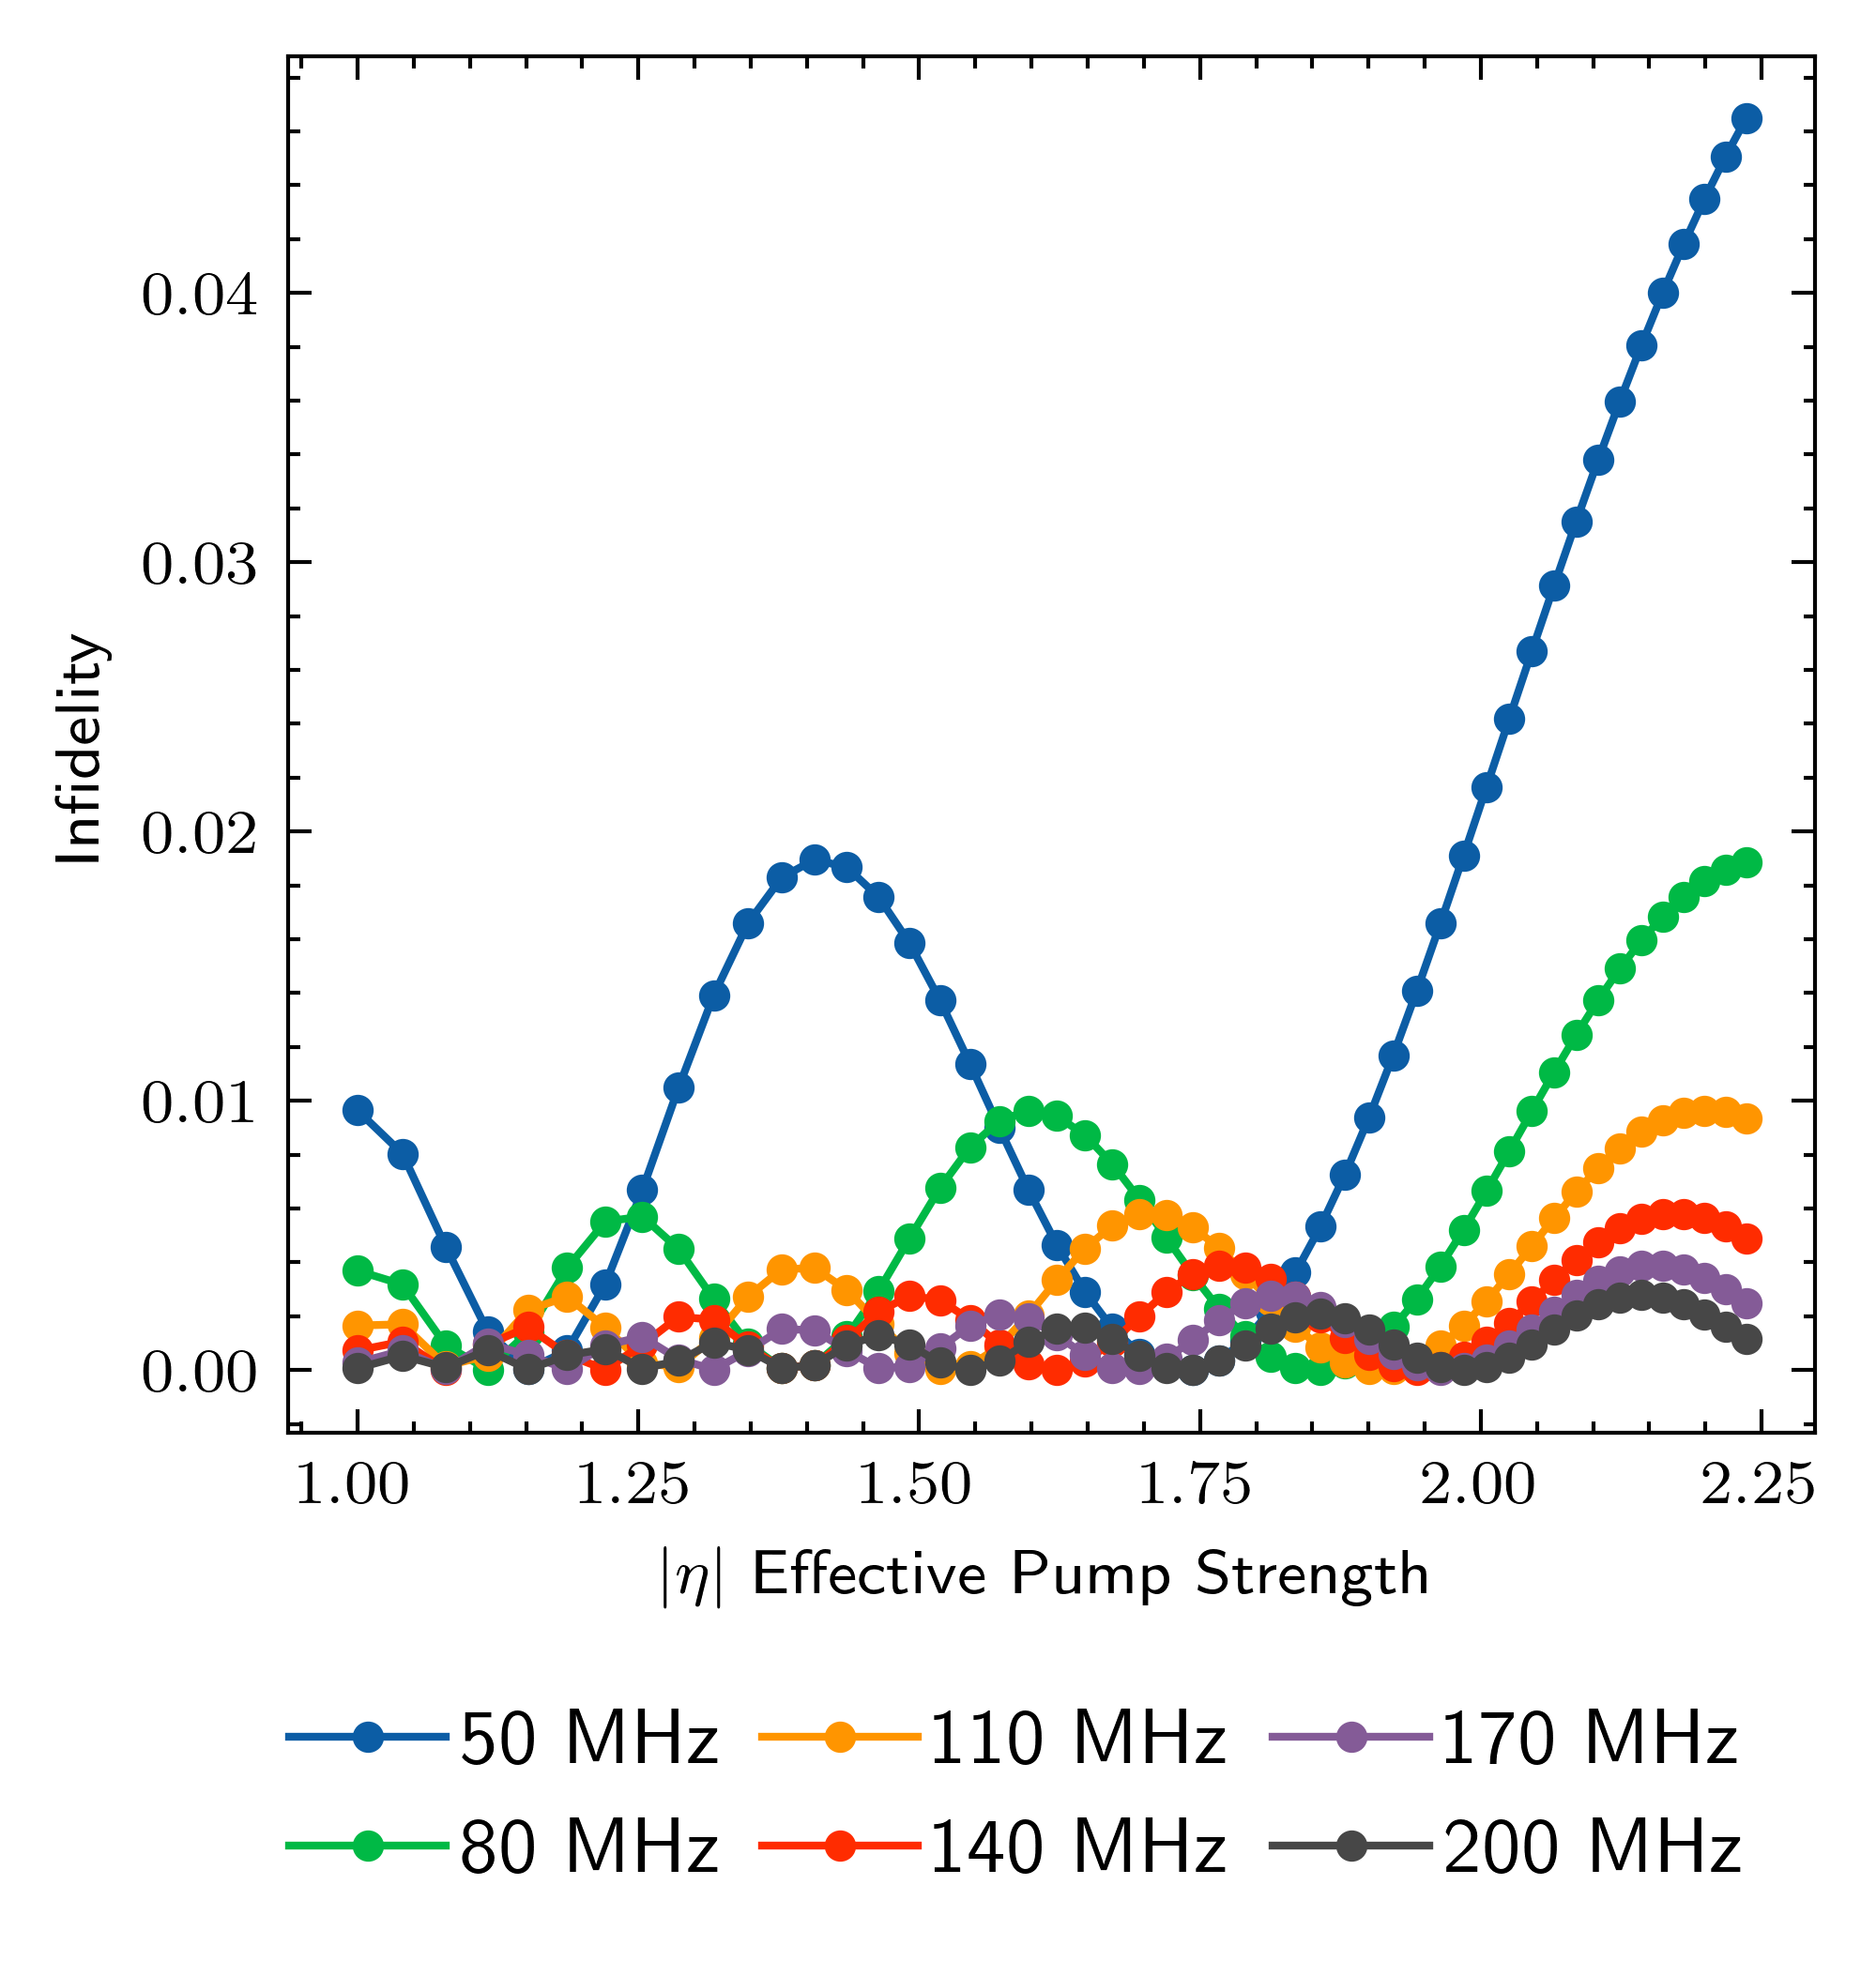

In [53]:
legend_offset = 0.15
with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, ax = plt.subplots(figsize=(3.5, 3.5 - legend_offset))

    # Plot fidelity as a function of eta for each delta
    for delta, fidelity_list in fidelity_dict.items():
        eta_list = np.array(eta_dict[delta])
        ax.plot(
            eta_list,
            fidelity_list,
            # label=r"$\delta_Q^{(2)} = $" + f"{delta / 1e6:.0f} MHz",
            label=f"{delta / 1e6:.0f} MHz",
            marker=".",
        )

    # Customize axes and labels
    ax.set_xlabel(r"$|\eta|$ Effective Pump Strength")
    ax.set_ylabel("Infidelity")

    # Adjust layout to include legend within the 3.5x3.5 inch constraint
    ax.legend(
        ncol=3,
        fontsize=10,
        bbox_to_anchor=(1.0, -legend_offset),
        handletextpad=0.2,  # Reduce padding between marker and label text
        columnspacing=0.5,  # Reduce space between columns
    )
    fig.subplots_adjust(bottom=legend_offset)  # Adjust bottom margin for legend

plt.show()
fig.savefig("fidelity_vs_eta.pdf", bbox_inches="tight")

  0%|          | 0/512 [00:00<?, ?it/s]

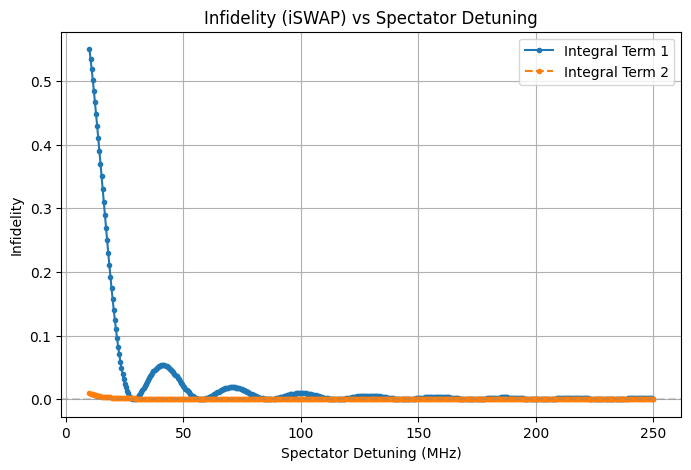

In [ ]:
# Parameter sweeps
delta_list = 1e6 * np.linspace(10, 250, 512)  # Fine-grain sweep over delta (MHz)

fidelity_dict1 = {}  # Store fidelity for integral_term1
fidelity_dict2 = {}  # Store fidelity for integral_term2
tf_dict = {}  # Store t_f values for each delta

for delta in tqdm(delta_list):
    g_eff = 6 * np.sqrt(4) * g3 * (lambdaq**2)  # Use n_s = 4 for sqrt(n_s) -> eta
    t_f = full_pulse / g_eff

    # Interaction terms
    interaction_term = q1dag * q2 + q1 * q2dag
    spectator_term = q3dag * q4 + q3 * q4dag
    # specator_term = q1dag + q1

    # Integral terms
    integral_term1 = 2 * np.sin(t_f * delta / 2) / delta
    integral_term2 = 2 / delta

    # Time evolution operators for both terms
    U_t_f1 = (
        1j * g_eff * (t_f * interaction_term + integral_term1 * spectator_term)
    ).expm()

    U_t_f2 = (
        1j * g_eff * (t_f * interaction_term + integral_term2 * spectator_term)
    ).expm()

    # Fidelity calculation
    target_iswap = tensor(intended_gate, qeye([2, 2]))  # Define the target iSWAP gate

    fidelity1 = 1 - average_gate_fidelity(U_t_f1, target_iswap)
    fidelity2 = 1 - average_gate_fidelity(U_t_f2, target_iswap)

    # Store fidelity and t_f values for current delta
    fidelity_dict1[delta] = fidelity1
    fidelity_dict2[delta] = fidelity2
    tf_dict[delta] = t_f

# Create a comparison plot: fidelity vs. detuning for both integral terms
plt.figure(figsize=(8, 5))

# Plot fidelity for integral_term1
deltas_mhz = np.array(delta_list) / 1e6  # Convert detuning to MHz
fidelity_values1 = [fidelity_dict1[delta] for delta in delta_list]
fidelity_values2 = [fidelity_dict2[delta] for delta in delta_list]

plt.plot(
    deltas_mhz,
    fidelity_values1,
    label="Integral Term 1",
    marker=".",
    linestyle="-",
)
plt.plot(
    deltas_mhz,
    fidelity_values2,
    label="Integral Term 2",
    marker=".",
    linestyle="--",
)

# Formatting the plot
plt.axhline(1 - 0.999, color="gray", linestyle="--", alpha=0.3)
plt.xlabel("Spectator Detuning (MHz)")
plt.ylabel("Infidelity")
plt.title("Infidelity (iSWAP) vs Spectator Detuning")
plt.legend(loc="upper right")
plt.grid(True)

# Display the plot
plt.show()

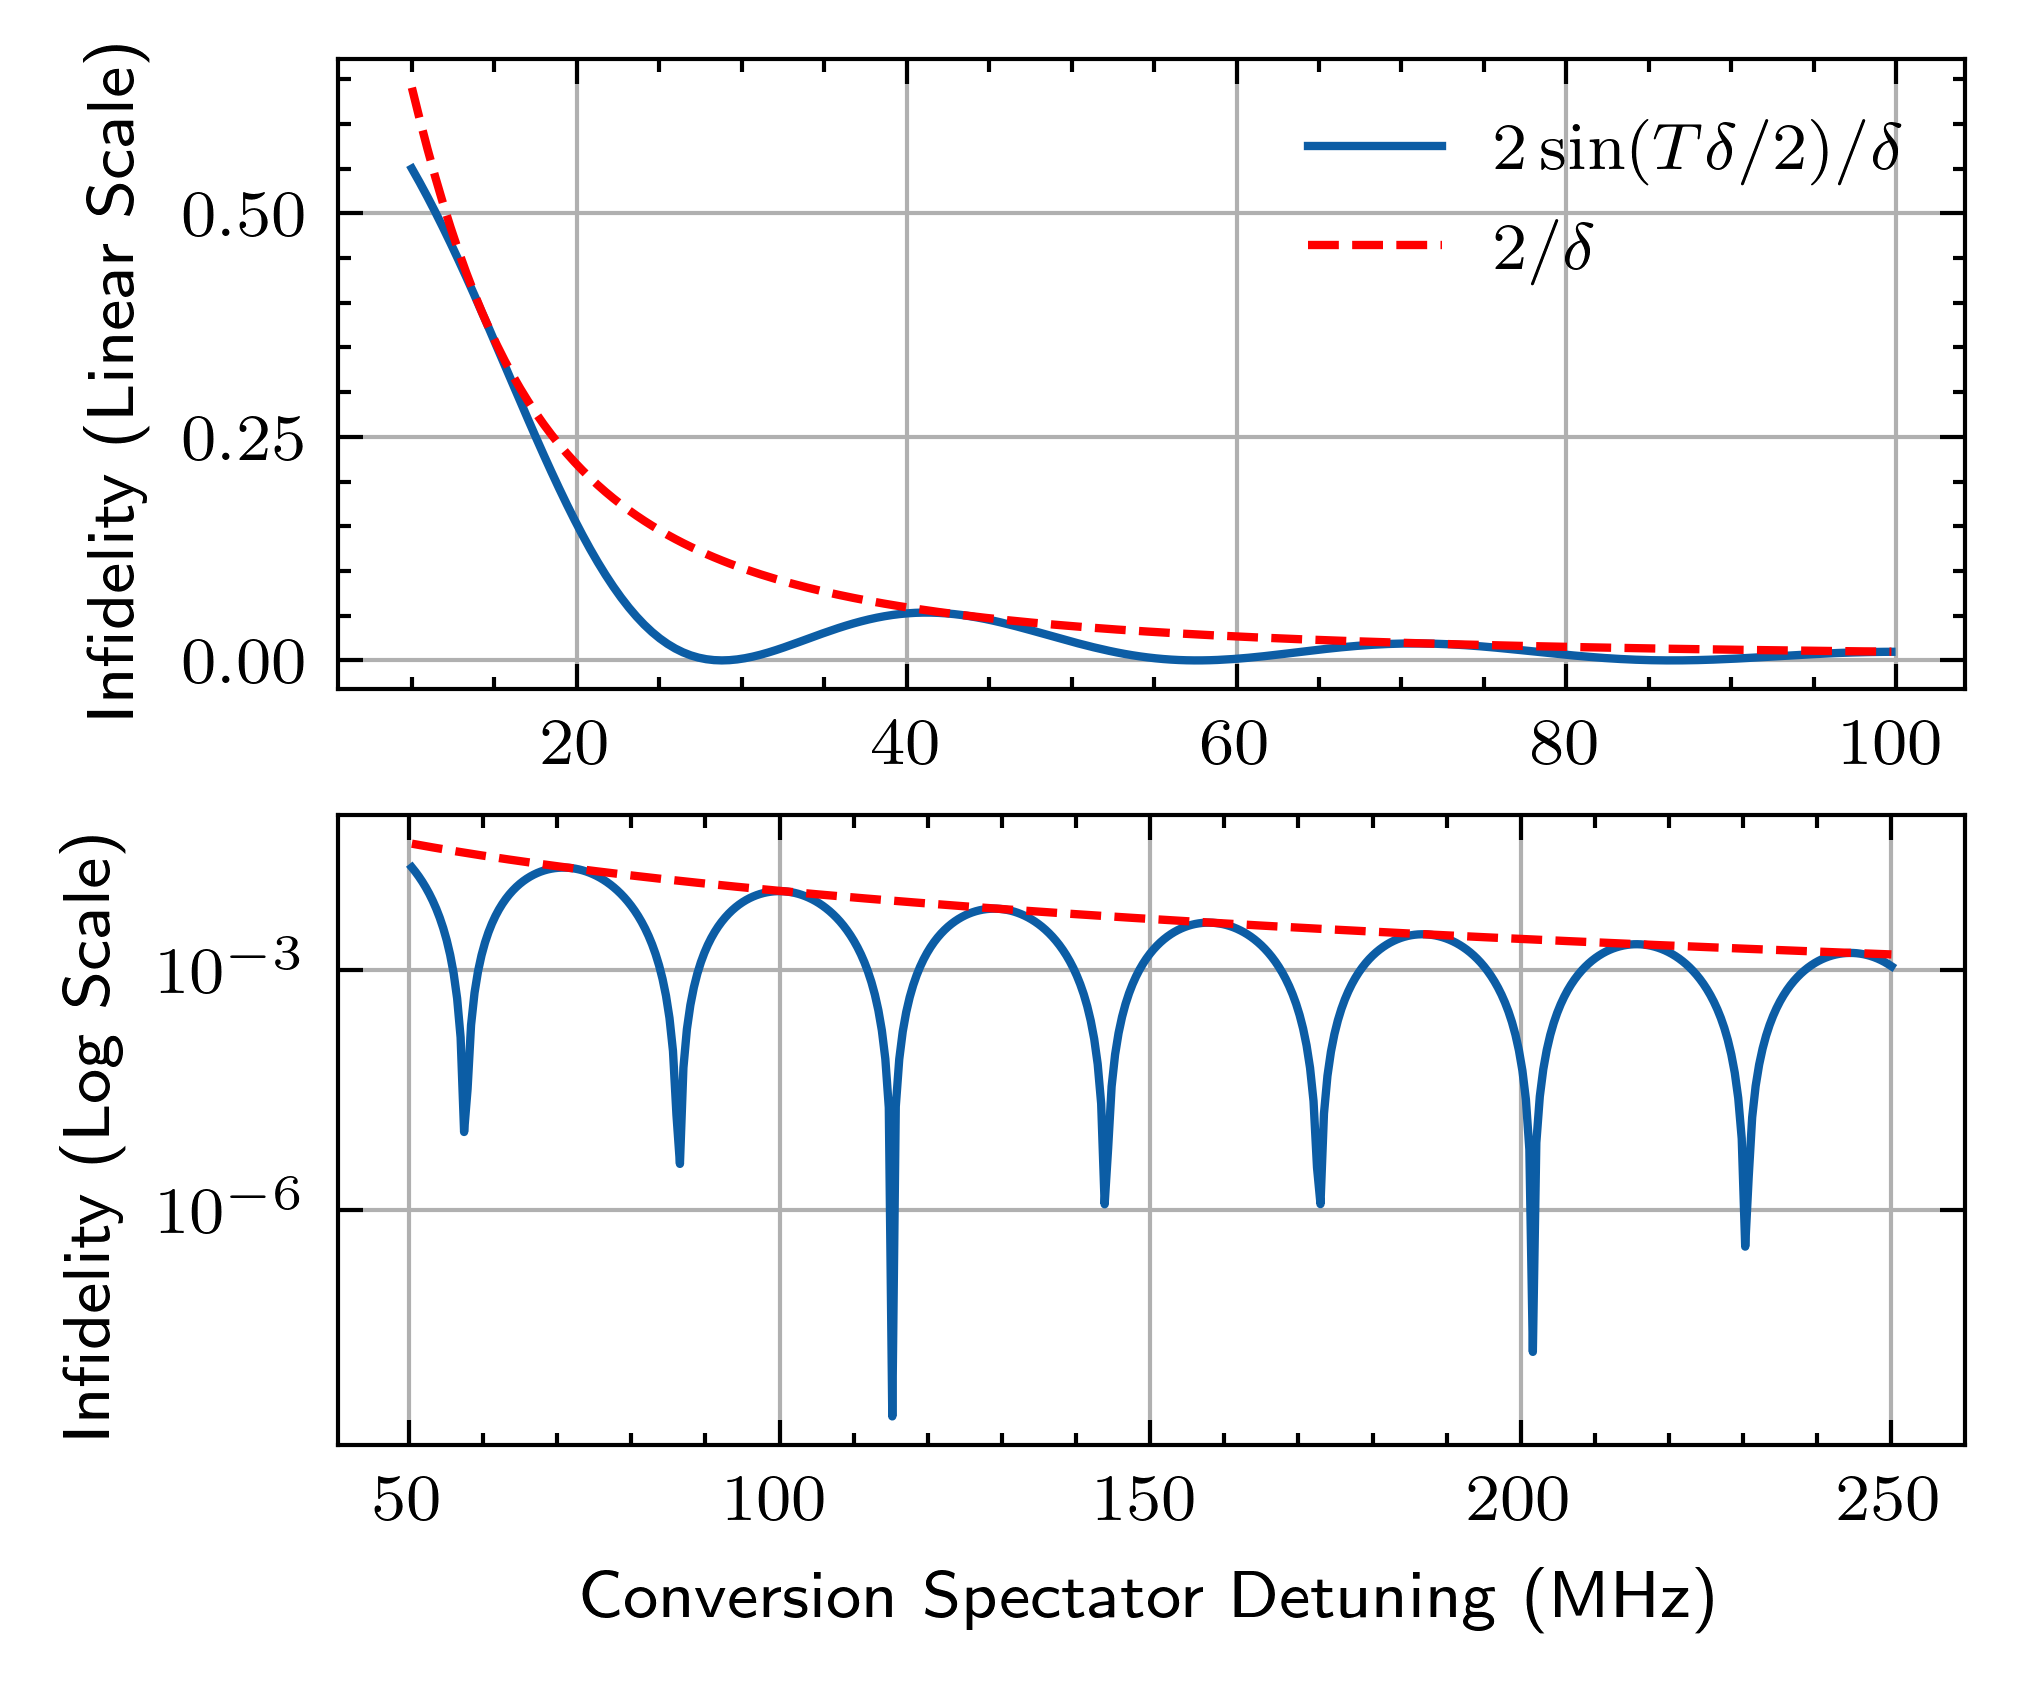

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Create the data for the two subplots
deltas_mhz = np.array(delta_list) / 1e6  # Convert detuning to MHz
fidelity_values1 = [fidelity_dict1[delta] for delta in delta_list]
fidelity_values2 = [fidelity_dict2[delta] for delta in delta_list]

# Create subplots
legend_offset = 0.2
with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, axs = plt.subplots(2, 1, figsize=(3.5, 3))  # , gridspec_kw={'hspace': 0.4})

    # Top subplot: 10 MHz to 100 MHz with linear y-axis
    ax = axs[0]
    mask = (deltas_mhz >= 10) & (deltas_mhz <= 100)
    ax.plot(
        deltas_mhz[mask],
        np.array(fidelity_values1)[mask],
        label="$2 \sin(T \delta / 2) / \delta$",
        linestyle="-",
    )
    ax.plot(
        deltas_mhz[mask],
        np.array(fidelity_values2)[mask],
        label="$2/ \delta$",
        linestyle="--",
        color="red",
    )
    ax.set_ylabel("Infidelity (Linear Scale)")
    ax.legend(fontsize=8)
    ax.grid(True)

    # Bottom subplot: 50 MHz to 250 MHz with log y-axis
    ax = axs[1]
    mask = (deltas_mhz >= 50) & (deltas_mhz <= 250)
    ax.plot(
        deltas_mhz[mask],
        np.array(fidelity_values1)[mask],
        label="$2 \sin(T \delta / 2) / \delta$",
        linestyle="-",
    )
    ax.plot(
        deltas_mhz[mask],
        np.array(fidelity_values2)[mask],
        label="$2/ \delta$",
        linestyle="--",
        color="red",
    )
    ax.set_xlabel("Conversion Spectator Detuning (MHz)")
    ax.set_ylabel("Infidelity (Log Scale)")
    ax.set_yscale("log")
    ax.grid(True)

# Save and display the plot
plt.show()
fig.savefig("fidelity_vs_detuning_subplots.pdf", bbox_inches="tight")

In [ ]:
# experiment 1
#  define qutip ladder operators
qs = destroy(2)
s = destroy(8)
qs1 = tensor(q, qeye(2), qeye(8))
qs2 = tensor(qeye(2), q, qeye(8))
s1 = tensor(qeye(2), qeye(2), s)
qs1dag = q1.dag()
qs2dag = q2.dag()
s1dag = s1.dag()

# Define two spectator terms for different types
spectator_term_snail_conversion = q1dag * s1 + q1 * s1dag

# experiment 2
# define qutip ladder operators
q = destroy(2)
q1 = tensor(q, qeye(2), qeye(2), qeye(2))
q2 = tensor(qeye(2), q, qeye(2), qeye(2))
q3 = tensor(qeye(2), qeye(2), q, qeye(2))
q4 = tensor(qeye(2), qeye(2), qeye(2), q)
q1dag = q1.dag()
q2dag = q2.dag()
q3dag = q3.dag()
q4dag = q4.dag()

spectator_term_conversion = q3dag * q4 + q3 * q4dag
spectator_term_subharmonic = q3dag + q3

In [ ]:
from qutip import destroy, tensor, qeye

# Device parameters
lambdaq = 0.08
eta = 1.8
alpha = 120e6  # 120 MHz
N_q = 4
g3 = 60e6  # Coupling strength g3 = 60 MHz

# Prefactor definitions
intra_prefactors = {
    "qubit-qubit": 6 * eta * lambdaq**2 * g3,
    "snail-qubit": 6 * eta * lambdaq * g3,
    "qubit-sub-1/2": 3 * eta**2 * lambdaq * g3,
}

inter_prefactors = {
    "qubit-qubit_1": 6 * eta * lambdaq**4 * g3,  # Partial overlap
    "qubit-qubit_0": 6 * eta * lambdaq**6 * g3,  # Neighbor
    "snail-qubit_1": 6 * eta * lambdaq**3 * g3,  # Partial overlap
    "snail-qubit_0": 6 * eta * lambdaq**5 * g3,  # Neighbor
    "qubit-sub-1/2": 3 * eta**2 * lambdaq**3 * g3,  # Non-overlapping
}

# Hilbert spaces
# 3-qubit system (can be extended if needed)
q = destroy(2)
q1 = tensor(q, qeye(2), qeye(2))  # First qubit
q2 = tensor(qeye(2), q, qeye(2))  # Second qubit
q3 = tensor(qeye(2), qeye(2), q)  # Third qubit
q1dag = q1.dag()
q2dag = q2.dag()
q3dag = q3.dag()

# 2 qubits + SNAIL system
n_dim_snail = 8
qs = destroy(2)
s = destroy(n_dim_snail)
qs1 = tensor(qs, qeye(2), qeye(n_dim_snail))
qs2 = tensor(qeye(2), qs, qeye(n_dim_snail))
s1 = tensor(qeye(2), qeye(2), s)
qs1dag = qs1.dag()
qs2dag = qs2.dag()
s1dag = s1.dag()

# Dictionary of spectator terms
spectator_terms = {
    # Qubit-Qubit Conversion
    "qubit-qubit intra": (intra_prefactors["qubit-qubit"], q1dag * q2 + q1 * q2dag),
    "qubit-qubit inter_1": (inter_prefactors["qubit-qubit_1"], q1dag * q3 + q1 * q3dag),
    "qubit-qubit inter_0": (inter_prefactors["qubit-qubit_0"], q3dag * q2 + q3 * q2dag),
    # SNAIL-Qubit Conversion
    "snail-qubit intra": (intra_prefactors["snail-qubit"], qs1dag * s1 + qs1 * s1dag),
    "snail-qubit inter_1": (
        inter_prefactors["snail-qubit_1"],
        qs1dag * s1 + qs1 * s1dag,
    ),
    "snail-qubit inter_0": (
        inter_prefactors["snail-qubit_0"],
        qs1dag * s1 + qs1 * s1dag,
    ),
    # Qubit Subharmonic
    "qubit-subharmonic intra": (intra_prefactors["qubit-sub-1/2"], q1dag + q1),
    "qubit-subharmonic inter_1": (inter_prefactors["qubit-sub-1/2"], q3dag + q3),
    "qubit-subharmonic inter_0": (inter_prefactors["qubit-sub-1/2"], q3dag + q3),
}

# Print the dictionary to verify
for key, value in spectator_terms.items():
    print(f"{key}: Prefactor = {value[0]:.2e}")  # Exclude the operator for readability

qubit-qubit intra: Prefactor = 4.15e+06
qubit-qubit inter_1: Prefactor = 2.65e+04
qubit-qubit inter_0: Prefactor = 1.70e+02
snail-qubit intra: Prefactor = 5.18e+07
snail-qubit inter_1: Prefactor = 3.32e+05
snail-qubit inter_0: Prefactor = 2.12e+03
qubit-subharmonic intra: Prefactor = 4.67e+07
qubit-subharmonic inter_1: Prefactor = 2.99e+05
qubit-subharmonic inter_0: Prefactor = 2.99e+05


In [126]:
from qutip import destroy, tensor, qeye, average_gate_fidelity
import numpy as np
import matplotlib.pyplot as plt

# Device parameters
lambdaq = 0.08
eta = 1.8
alpha = 120e6  # 120 MHz
N_q = 4
g3 = 60e6  # Coupling strength g3 = 60 MHz

# Prefactor definitions
intra_prefactors = {
    "qubit-qubit": 6 * eta * lambdaq**2 * g3,
    "snail-qubit": 6 * eta * lambdaq * g3,
    "qubit-sub-1/2": 3 * eta**2 * lambdaq * g3,
}

inter_prefactors = {
    "qubit-qubit_1": 6 * eta * lambdaq**4 * g3,  # Partial overlap
    "qubit-qubit_0": 6 * eta * lambdaq**6 * g3,  # Neighbor
    "snail-qubit_1": 6 * eta * lambdaq**3 * g3,  # Partial overlap
    "snail-qubit_0": 6 * eta * lambdaq**5 * g3,  # Neighbor
    "qubit-sub-1/2": 3 * eta**2 * lambdaq**3 * g3,  # Non-overlapping
}

# Hilbert spaces
q = destroy(2)
q1 = tensor(q, qeye(2), qeye(2), qeye(2))
q2 = tensor(qeye(2), q, qeye(2), qeye(2))
q3 = tensor(qeye(2), qeye(2), q, qeye(2))
q4 = tensor(qeye(2), qeye(2), qeye(2), q)
q1dag = q1.dag()
q2dag = q2.dag()
q3dag = q3.dag()
q4dag = q4.dag()

# 2 qubits + SNAIL system
qs = destroy(2)
n_dim_snail = 8
s = destroy(n_dim_snail)
qs1 = tensor(qs, qeye(2), qeye(n_dim_snail))
qs2 = tensor(qeye(2), qs, qeye(n_dim_snail))
s1 = tensor(qeye(2), qeye(2), s)
qs1dag = qs1.dag()
qs2dag = qs2.dag()
s1dag = s1.dag()

# Intended gate: iSWAP between q1 and q2
intended_term = q1dag * q2 + q1 * q2dag
ideal_gate = (-1.0j * (np.pi / 2) * intended_term).expm()

s_intended_term = qs1dag * qs2 + qs1 * qs2dag
s_ideal_gate = (-1.0j * (np.pi / 2) * s_intended_term).expm()

# Spectator terms and their prefactors
spectator_terms = {
    "snail-qubit": (intra_prefactors["snail-qubit"], qs1dag * s1 + qs1 * s1dag),
    "qubit subharmonic": (intra_prefactors["qubit-sub-1/2"], q1dag + q1),
    "qubit-qubit": (intra_prefactors["qubit-qubit"], q1dag * q2 + q1 * q2dag),
    "qubit-qubit inter_1": (inter_prefactors["qubit-qubit_1"], q1dag * q3 + q1 * q3dag),
    "qubit-qubit inter_0": (inter_prefactors["qubit-qubit_0"], q3dag * q4 + q3 * q4dag),
    "snail-qubit (inter)": (
        inter_prefactors["snail-qubit_1"],
        qs2dag * s1 + qs2 * s1dag,
    ),
    "snail-qubit inter_0": (
        inter_prefactors["snail-qubit_0"],
        qs2dag * s1 + qs2 * s1dag,
    ),
    "qubit subharmonic (inter)": (inter_prefactors["qubit-sub-1/2"], q3dag + q3),
}

# Detuning list (MHz)
detuning_list = np.linspace(10, 1000, 64)

# Calculate fidelities
fidelity_results = {}
for label, (prefactor, spectator_term) in spectator_terms.items():
    fidelity_list = []
    for detuning in detuning_list:
        spectator_amplitude = (
            2 * prefactor / (2 * np.pi * detuning * 1e6)
        )  # Calculate amplitude
        # Define the Hamiltonian with spectator term
        if "snail-qubit" in label:
            H = s_intended_term + spectator_amplitude * spectator_term
            U_t_f = (-1.0j * (np.pi / 2) * H).expm()
            fidelity = 1 - average_gate_fidelity(U_t_f, s_ideal_gate)
        else:
            H = intended_term + spectator_amplitude * spectator_term
            U_t_f = (-1.0j * (np.pi / 2) * H).expm()
            fidelity = 1 - average_gate_fidelity(U_t_f, ideal_gate)
        fidelity_list.append(fidelity)
    fidelity_results[label] = fidelity_list

In [ ]:
# Set up plot
with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, ax = plt.subplots(figsize=(3.5, 2.6))

    for label, fidelities in fidelity_results.items():
        ax.plot(detuning_list, fidelities, label=label, marker=".")

    ax.set_xlabel("Detuning (MHz)")
    ax.set_ylabel("Infidelity")
    ax.set_yscale("log")
    # legend on the bottom
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.2),
        ncol=2,
        fontsize=10,
        # handletextpad=0.2,
        columnspacing=0.5,
    )
    # fig.savefig("fidelity_vs_terms.pdf", bbox_inches="tight")
plt.show()

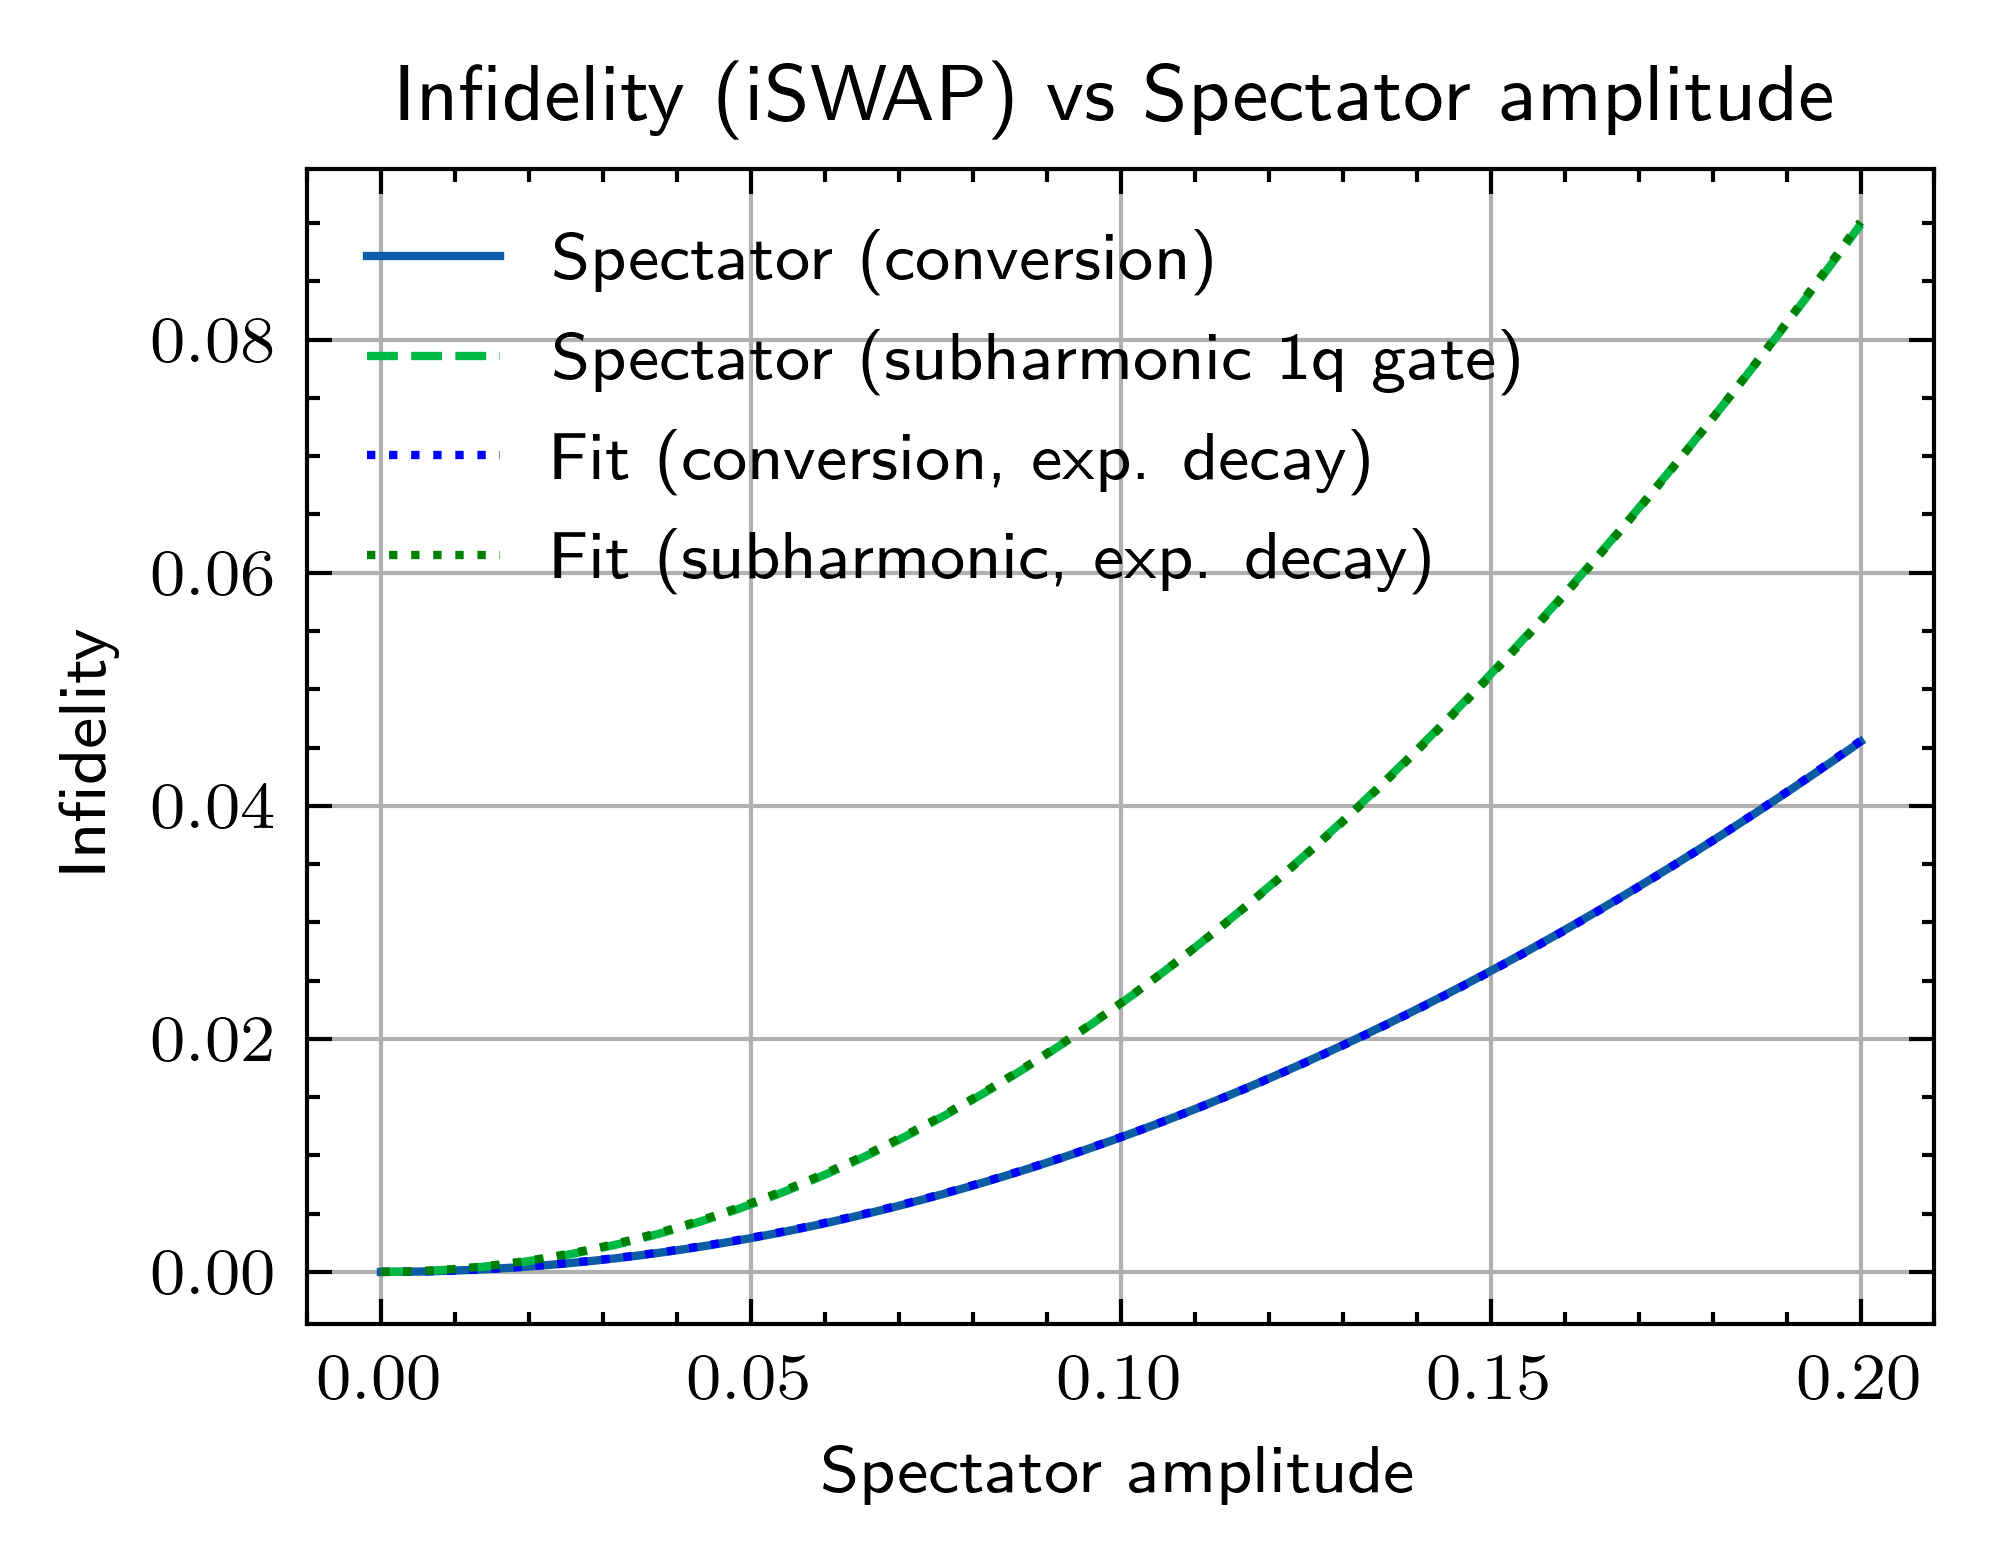

Fitted Parameters (Conversion):
a = 1.101, b = 1.979
Fitted Parameters (Subharmonic):
a = 2.133, b = 1.966


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Fit fidelity data to the exponential decay function
spectator_amplitude_list = np.array(spectator_amplitude_list)
fidelity_list_conversion = np.array(fidelity_list_conversion)
fidelity_list_subharmonic = np.array(fidelity_list_subharmonic)

# Fit conversion data
params_conversion, _ = curve_fit(
    exponential_decay, spectator_amplitude_list, fidelity_list_conversion, p0=[0, 0]
)
# Fit subharmonic data
params_subharmonic, _ = curve_fit(
    exponential_decay, spectator_amplitude_list, fidelity_list_subharmonic, p0=[0, 0]
)

# Generate fitted curves
fit_conversion = exponential_decay(spectator_amplitude_list, *params_conversion)
fit_subharmonic = exponential_decay(spectator_amplitude_list, *params_subharmonic)

# Plot the data and the fitted curves
with plt.style.context(["ieee", "use_mathtext", "science"]):
    plt.figure(figsize=(3.5, 2.5))

    # Original fidelity curves
    plt.plot(
        spectator_amplitude_list,
        fidelity_list_conversion,
        label="Spectator (conversion)",
        linestyle="-",
    )
    plt.plot(
        spectator_amplitude_list,
        fidelity_list_subharmonic,
        label="Spectator (subharmonic 1q gate)",
        linestyle="--",
    )

    # Fitted curves
    plt.plot(
        spectator_amplitude_list,
        fit_conversion,
        label="Fit (conversion, exp. decay)",
        linestyle=":",
        color="blue",
    )
    plt.plot(
        spectator_amplitude_list,
        fit_subharmonic,
        label="Fit (subharmonic, exp. decay)",
        linestyle=":",
        color="green",
    )

    # Add labels and legend
    plt.xlabel("Spectator amplitude")
    plt.ylabel("Infidelity")
    plt.title("Infidelity (iSWAP) vs Spectator amplitude")
    plt.legend(fontsize=8)
    plt.grid(True)

# Show the plot
plt.show()

# Print fitted parameters
print("Fitted Parameters (Conversion):")
print(f"a = {params_conversion[0]:.3f}, b = {params_conversion[1]:.3f}")

print("Fitted Parameters (Subharmonic):")
print(f"a = {params_subharmonic[0]:.3f}, b = {params_subharmonic[1]:.3f}")

Next, I need to justify the approximations used in the model:

that we can use only 4 qubits (1 spectator pair used twice) instead of 6 qubits (2 pairs of spectators) provided we have the right scaling factor $1/\log{2}$

  0%|          | 0/50 [00:00<?, ?it/s]

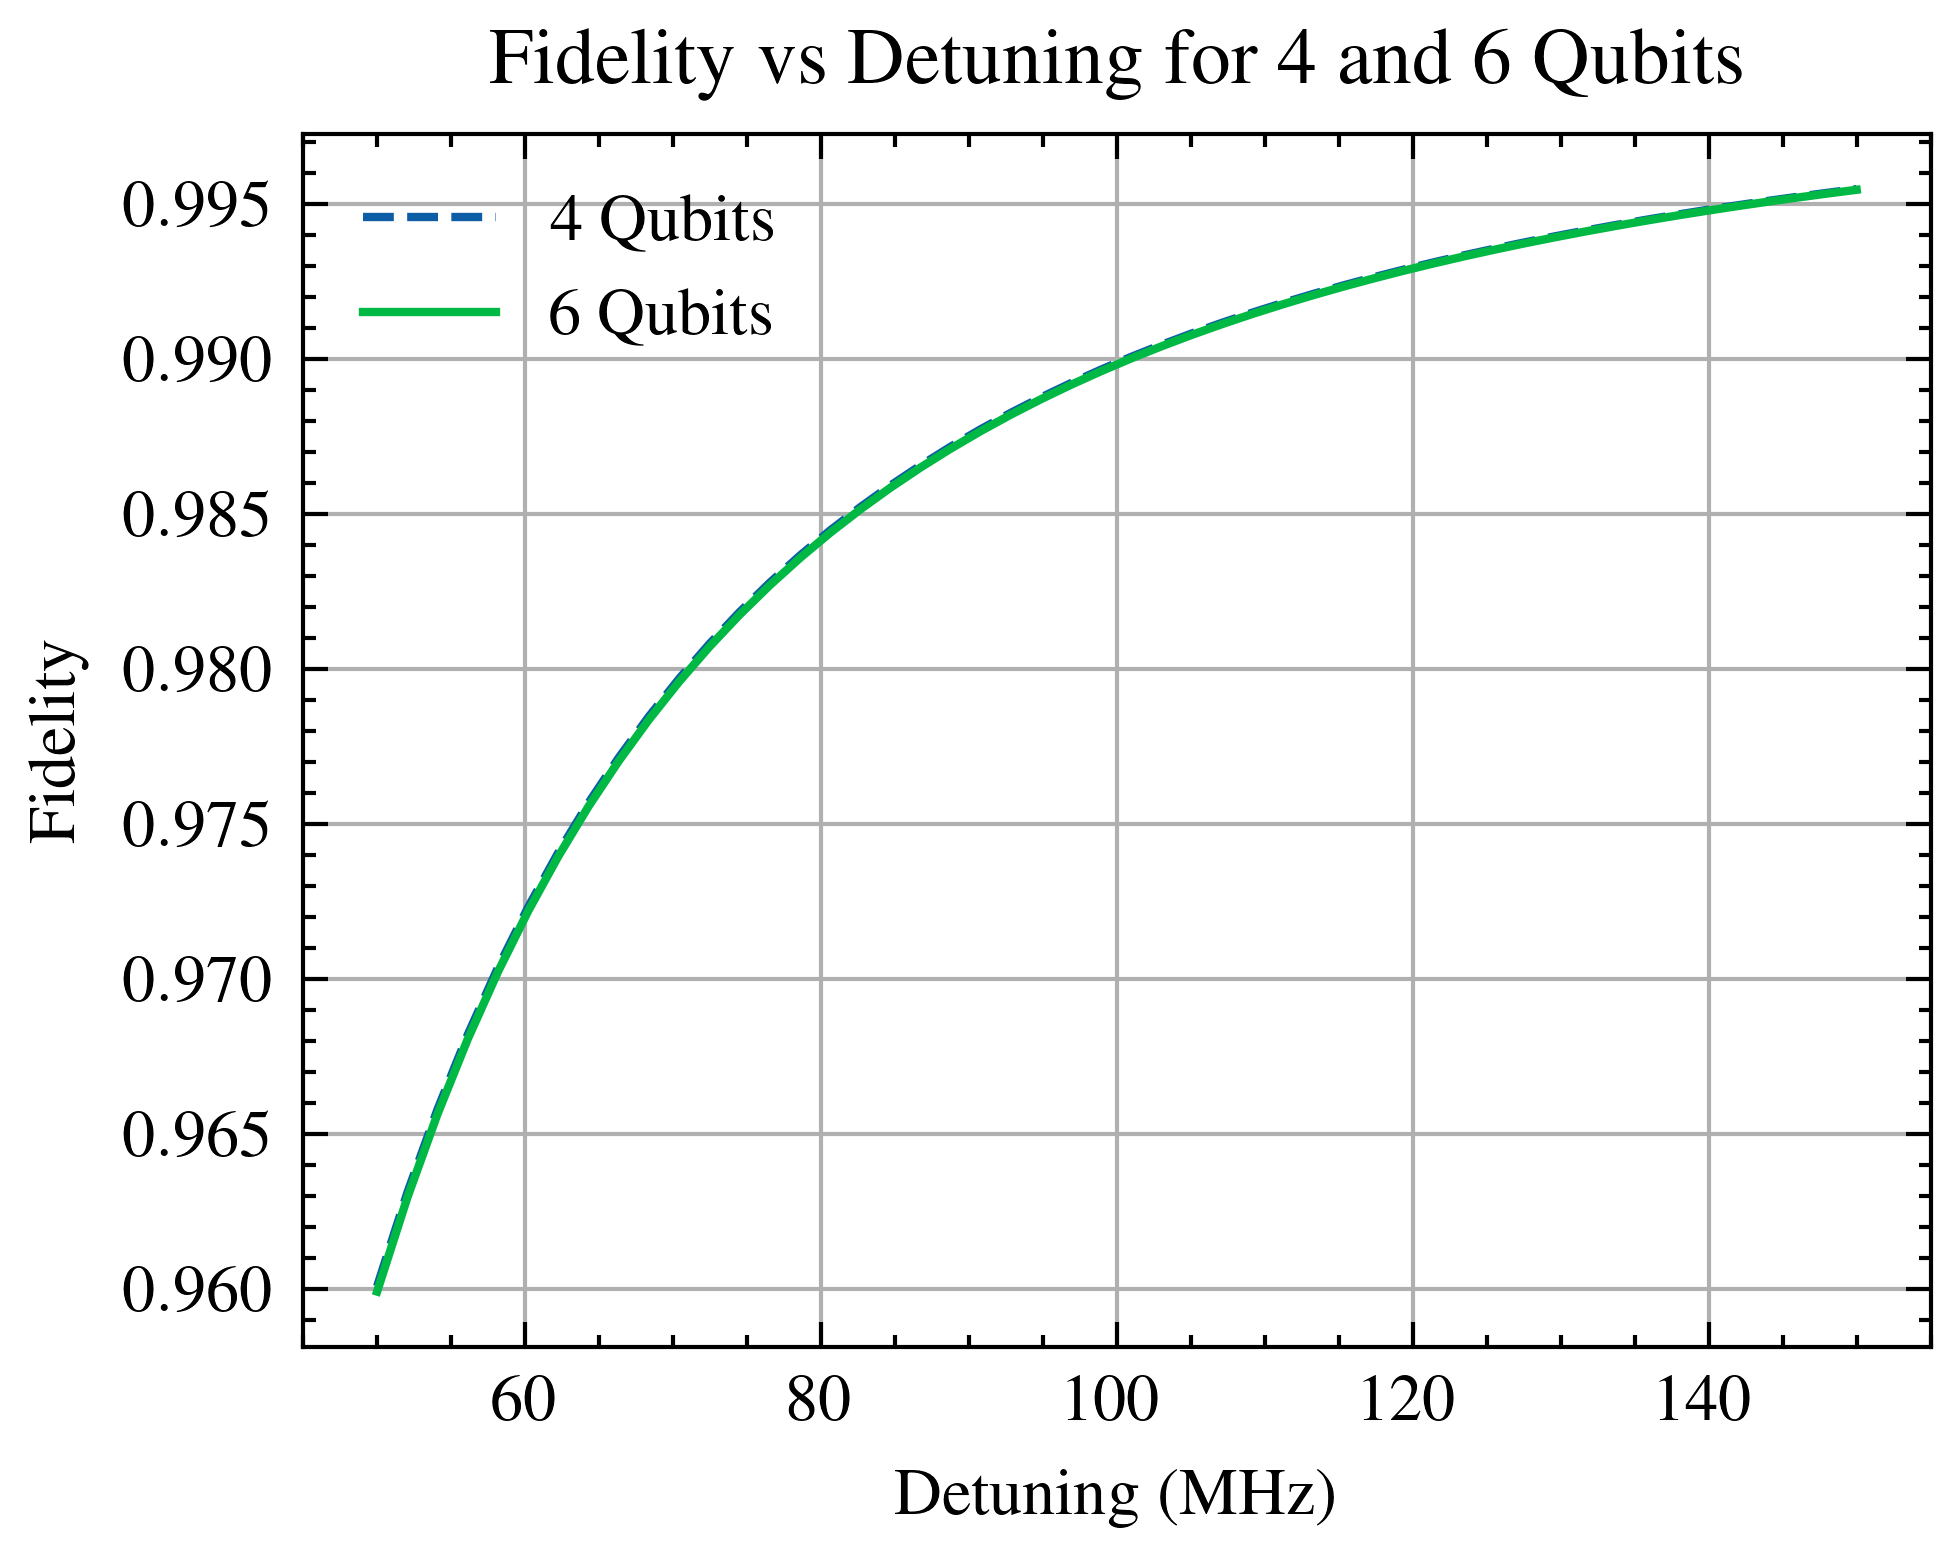

In [37]:
def build_propagator6(delta, lambdaq=0.1, g3=60e6, n_s=2, full_pulse=np.pi / 2):
    """Build propagator using 6 total qubits."""
    num_qubits = 6
    q1, q2, q3, q4, q5, q6 = [
        tensor(*[destroy(2) if i == j else qeye(2) for i in range(num_qubits)])
        for j in range(num_qubits)
    ]
    # Calculate effective coupling and gate duration t_f
    eta = np.sqrt(n_s)
    g_eff = 6 * g3 * (lambdaq**2) * eta
    t_f = full_pulse / g_eff  # Duration of the gate based on effective coupling

    # Define the target and spectator interactions
    target_interaction = q1.dag() * q2 + q1 * q2.dag()
    spectator_interaction1 = q3.dag() * q4 + q3 * q4.dag()
    spectator_interaction2 = q5.dag() * q6 + q5 * q6.dag()

    # Build the total Hamiltonian as a list of time-dependent components
    H_int = g_eff * target_interaction * t_f + g_eff * 2 / delta * (
        spectator_interaction1 + spectator_interaction2
    )
    U_spec = (1j * H_int).expm()

    return U_spec


def build_propagator4(delta, lambdaq=0.1, g3=60e6, n_s=2, full_pulse=np.pi / 2):
    """Build propagator using 4 total qubits, including a scaling prefactor."""
    num_qubits = 4
    q1, q2, q3, q4 = [
        tensor(*[destroy(2) if i == j else qeye(2) for i in range(num_qubits)])
        for j in range(num_qubits)
    ]

    # Calculate effective coupling and gate duration t_f
    eta = np.sqrt(n_s)
    g_eff = 6 * g3 * (lambdaq**2) * eta
    t_f = full_pulse / g_eff  # Duration of the gate based on effective coupling

    # Define the target and spectator interactions
    target_interaction = q1.dag() * q2 + q1 * q2.dag()
    spectator_interaction1 = q3.dag() * q4 + q3 * q4.dag()

    # Build the total Hamiltonian as a list of time-dependent components'
    constant = 1 / np.log(2)
    H_int = g_eff * target_interaction * t_f + constant * g_eff * 2 / delta * (
        spectator_interaction1
    )
    U_spec = (1j * H_int).expm()

    return U_spec


# Ueff = build_propagator6(100e6, lambdaq=0.1, g3=60e6, n_s=2, full_pulse=np.pi / 2)
# Udesired = tensor(ISWAP([0, 1]).get_compact_qobj(), qeye([2, 2, 2, 2]))
# average_gate_fidelity(Ueff, Udesired)

# Ueff = build_propagator4(100e6, lambdaq=0.1, g3=60e6, n_s=2, full_pulse=np.pi / 2)
# Udesired = tensor(ISWAP([0, 1]).get_compact_qobj(), qeye([2, 2]))
# average_gate_fidelity(Ueff, Udesired)


detunings = np.linspace(50e6, 150e6, N)  # Detuning range for plot
fid4 = []
fid6 = []

Udesired4 = tensor(ISWAP([0, 1]).get_compact_qobj(), qeye([2, 2]))
Udesired6 = tensor(ISWAP([0, 1]).get_compact_qobj(), qeye([2, 2, 2, 2]))

for delta in tqdm(detunings):

    # Calculate fidelities for 1 and 2 spectators
    Ueff = build_propagator4(delta, lambdaq=0.1, g3=60e6, n_s=2, full_pulse=np.pi / 2)
    fid4.append(average_gate_fidelity(Ueff, Udesired4))

    Ueff = build_propagator6(delta, lambdaq=0.1, g3=60e6, n_s=2, full_pulse=np.pi / 2)
    fid6.append(average_gate_fidelity(Ueff, Udesired6))

# Plot the results
with plt.style.context(["ieee", "use_mathtext", "science"]):
    plt.figure()
    plt.plot(detunings / 1e6, fid4, label="4 Qubits", linestyle="--")
    plt.plot(detunings / 1e6, fid6, label="6 Qubits", linestyle="-")
    plt.xlabel("Detuning (MHz)")
    plt.ylabel("Fidelity")
    plt.title("Fidelity vs Detuning for 4 and 6 Qubits")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def increment_unit(channel: int, last_value):
    """Increase voltage by single bit"""
    last_value = "000101010"
    register_contents = int(register_contents, 2) + 1
    register_contents = bin(register_contents)[2:].zfill(18)
    print(register_contents)


increment_unit()

TypeError: increment_unit() missing 2 required positional arguments: 'channel' and 'last_value'